# Models for Automating Project Management 

In [2037]:
from mesa import Agent, Model 

In [2038]:
from mesa.time import RandomActivation, BaseScheduler 

In [2039]:
from mesa.datacollection import DataCollector
import random 
import datetime

## Automated Scheduler 
### Based on Tasks and the Team 

**Scope**: The goal of this model is to create potential schedules given a team with attributes and tasks with attributes. The tasks will be ordered by due date. The "tick" or time step size will be one day, and productivity will be defined as work/day. Each team member will only be allowed to work on one task. Date will be tracked in the model, and tasks will be marked as late and tracked in order to visualize task completion success. 

### Team Member Agent 

In [2040]:
class TeamMember(Agent):
    def __init__(self, unique_id, model, name, expertise, competency):
        super().__init__(unique_id, model)
        self.name = name
        self.available = True 
        self.num_tasks_completed = 0
        self.task = None 
        self.expertise = expertise
        self.competency = competency
        
    def step(self):
        
        #assigning task if agent is available 
        if self.available: 
            for task in self.model.schedule.agents: 
                if task.state == "open" and self.expertise >= task.expertise and any(x in task.competency for x in self.competency):
                    task.state = "in_progress"
                    task.start_date = self.model.date.isoformat()
                    task.human = self.name
                    self.task = task
                    self.available = False
                    return 
                
        #if busy working on something, update task information 
        else:
            self.task.duration -= 1
            if self.task.duration <= 0:
                self.available = True
                self.task.state = "complete"
                self.task.end_date = self.model.date.isoformat()
                self.task = None
                self.num_tasks_completed += 1
                self.model.tasks_closed += 1
                return 
        

### Task Agent

In [2041]:
class Task(Agent):
    def __init__(self, unique_id, model, name, duration, expertise, competency):
        super().__init__(unique_id, model)
        self.name = name
        self.state = "open"
        self.duration = duration
        self.expertise = expertise
        self.complete = False
        self.start_date = None
        self.end_date = None
        self.human = None
        self.competency = competency 
        

### Model 

In [2042]:
class Scheduler(Model):
    def __init__(self, team, tasks):
        self.team = team
        self.schedule = BaseScheduler(self)
        self.staff_schedule = BaseScheduler(self)
        self.perc_late_tasks = 0
        self.tasks_closed = 0
        self.date = datetime.datetime.now().date() 
        
        #building our team agents
        for i in range(len(team)):
            m = TeamMember(i, self, team[i]['name'], team[i]['expertise'], team[i]['competency'])
            self.staff_schedule.add(m)
        
        #building our task agents
        for j in range(len(tasks)):
            t = Task(j, self, tasks[j]['name'], tasks[j]['duration'], tasks[j]['expertise'], tasks[j]['competency'])
            self.schedule.add(t)
        
        #adding in our datacollector 
        self.datacollector = DataCollector(
            model_reporters={"Tasks Closed": "tasks_closed"}, 
            agent_reporters={"Task": "name", "Start": "start_date", "Finish":"end_date", "Human": "human", "Expertise":"expertise"}
        )

    def step(self):
        self.date = self.date + datetime.timedelta(days=1)
        self.schedule.step()
        self.staff_schedule.step()
        self.datacollector.collect(self)

### Building and Running Our Scheduler

#### First - We Need A Team 

In [2083]:
team_list = [
    {
        "name": "Anthony", 
        "expertise": 2, 
        "competency": ['Redux', 'React', 'Angular']
    },
    {
        "name": "George", 
        "expertise": 3, 
        "competency": ['Ruby on Rails', 'React', 'REST API', 'Python']
    }, 
    {
        "name": "Elizabeth", 
        "expertise": 1, 
        "competency": ['React', 'Angular', 'Redux']
    }, 
    {
        "name": "Ron", 
        "expertise": 3, 
        "competency": ['Ruby on Rails', 'React', 'REST API', 'Python', 'Angular'] 
    } 
]

#### Second - We Need Tasks (note: we are going to sort this data based on time_remaining before passing to the model.

In [2084]:
competency_list = ['Redux', 'Ruby on Rails', 'React', 'Python', 'Angular', 'REST API']

In [2097]:
def task_list_generator(num_tasks):
    temp = []
    for i in range(num_tasks):
        temp_task = {}
        temp_task['name'] = "Task Number " + str(i)
        temp_task['duration'] = random.randrange(4, 10)
        temp_task['expertise'] = random.choice([1, 2, 3])
        temp_task['competency'] = random.choice(competency_list)
        temp.append(temp_task)
    return temp
        

In [2098]:
tasks_list = task_list_generator(15)

#### Plug our Team and Tasks into the Model 

In [2099]:
model = Scheduler(team_list, tasks_list)

##### Simulate for Defined Amount of Days 

In [2100]:
days_of_simulation = 60

In [2101]:
for i in range(days_of_simulation): 
    model.step()

##### Pulling Data From the Data Collector and Plotting 

In [2102]:
model_df = model.datacollector.get_model_vars_dataframe()

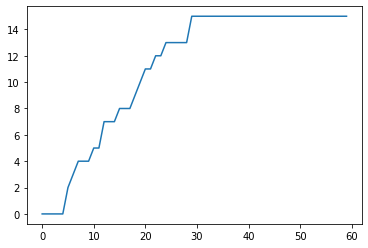

In [2103]:
model_df['Tasks Closed'].plot()

### Visualizing Schedules  

In [2104]:
import plotly.express as px
import pandas as pd

In [2105]:
task_dict = []
for agent in model.schedule.agents: 
    task_dict.append({"Task": agent.name, "Start": agent.start_date, "Finish": agent.end_date, "Human": agent.human, "Expertise": agent.expertise, "Competency": agent.competency})

In [2106]:
df = pd.DataFrame(task_dict)

In [2107]:
fig = px.timeline(df, x_start="Start", x_end="Finish", y="Human", color="Task", height=300, text="Competency")

In [2108]:
fig.show()